<a href="https://colab.research.google.com/github/MPGarg/Assignment-8/blob/main/EVA8_Assigment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
#!pip install -U albumentations
!pip install torch_lr_finder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import files from GIT Hub

In [3]:
!git clone https://github.com/MPGarg/main_repo.git

Cloning into 'main_repo'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 85 (delta 14), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (85/85), 32.05 KiB | 994.00 KiB/s, done.


# Custom ResNet class is imported

In [4]:
from main_repo.models import custom_resnet
from main_repo.models.custom_resnet import Custom_ResNet

# Import Other fuctions

In [5]:
from main_repo import main, utils
from main_repo.utils import *    
from main_repo.main import train, test, fit_model

# Assign device

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [7]:
view_model = Custom_ResNet().to(device)
summary(view_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
         Dropout2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
        Dropout2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Show sample images and Load dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


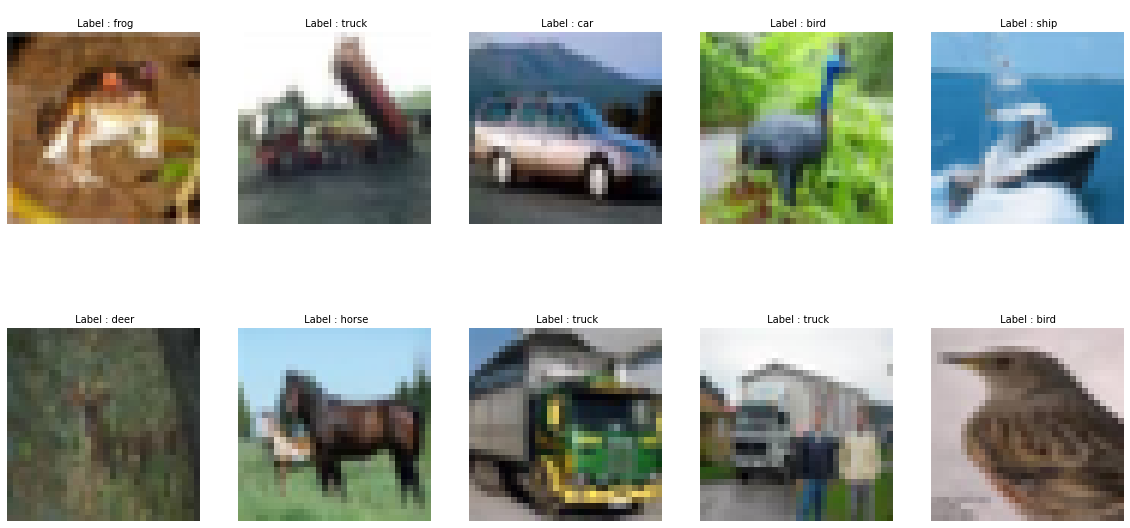

In [8]:
trainset_mod, trainloader_mod, testset_mod, testloader_mod,mean, std = process_dataset(visualize = 'X')     

# Find Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.40E-02


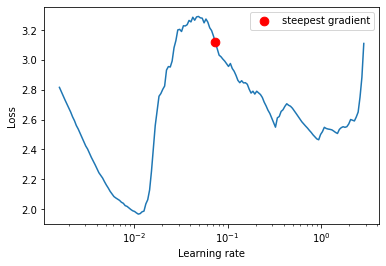

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3a343eb310>,
 0.07401959996915644)

In [13]:
import copy
model = Custom_ResNet(0.05).to(device)
model_exp = copy.deepcopy(model)
optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.001, momentum=0.9,weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader_mod, end_lr=10, num_iter=200)
lr_finder.plot() 

In [14]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.011097524964120722


# Train & Test Model

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=ler_rate/10, momentum=0.9,weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader_mod), 
                                                epochs=24,
                                                pct_start=0.15,
                                                div_factor=10,
                                                three_phase=False, 
                                                #final_div_factor=1000,
                                                anneal_strategy='linear'
                                                ) 

model_tr, wrong_prediction_list, right_prediction_list, train_losses, train_acc, test_losses, test_acc = fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=trainloader_mod, 
                                                    testloader=testloader_mod,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler
                                                    
                                                )

EPOCH: 1 (LR: 0.0011097524964120721)


100%|██████████| 98/98 [00:25<00:00,  3.92it/s]


Average Training Loss=0.0034691700100898744, Accuracy=36.792


Test set: Average loss: 0.0026, Accuracy: 5340/10000 (53.40%)

EPOCH: 2 (LR: 0.0038920199831529697)


100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Average Training Loss=0.0023865499234199524, Accuracy=56.21


Test set: Average loss: 0.0020, Accuracy: 6325/10000 (63.25%)

EPOCH: 3 (LR: 0.006674287469893867)


100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


Average Training Loss=0.001885912836790085, Accuracy=66.024


Test set: Average loss: 0.0018, Accuracy: 6809/10000 (68.09%)

EPOCH: 4 (LR: 0.009456554956634763)


100%|██████████| 98/98 [00:25<00:00,  3.87it/s]


Average Training Loss=0.0015246072244644165, Accuracy=72.806


Test set: Average loss: 0.0015, Accuracy: 7476/10000 (74.76%)

EPOCH: 5 (LR: 0.010874377684032377)


100%|██████████| 98/98 [00:25<00:00,  3.86it/s]


Average Training Loss=0.0013345898604393005, Accuracy=76.072


Test set: Average loss: 0.0012, Accuracy: 7980/10000 (79.80%)

EPOCH: 6 (LR: 0.010330386802224971)


100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


Average Training Loss=0.001154441841840744, Accuracy=79.748


Test set: Average loss: 0.0011, Accuracy: 8183/10000 (81.83%)

EPOCH: 7 (LR: 0.009786395920417567)


100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


Average Training Loss=0.0010220497524738312, Accuracy=82.134


Test set: Average loss: 0.0010, Accuracy: 8341/10000 (83.41%)

EPOCH: 8 (LR: 0.00924240503861016)


100%|██████████| 98/98 [00:25<00:00,  3.86it/s]


Average Training Loss=0.0009328387862443924, Accuracy=83.864


Test set: Average loss: 0.0009, Accuracy: 8514/10000 (85.14%)

EPOCH: 9 (LR: 0.008698414156802755)


100%|██████████| 98/98 [00:25<00:00,  3.87it/s]


Average Training Loss=0.0008505505502223969, Accuracy=85.154


Test set: Average loss: 0.0009, Accuracy: 8466/10000 (84.66%)

EPOCH: 10 (LR: 0.008154423274995347)


100%|██████████| 98/98 [00:25<00:00,  3.86it/s]


Average Training Loss=0.000771017672419548, Accuracy=86.51


Test set: Average loss: 0.0008, Accuracy: 8603/10000 (86.03%)

EPOCH: 11 (LR: 0.007610432393187942)


100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


Average Training Loss=0.0007185930705070495, Accuracy=87.45


Test set: Average loss: 0.0008, Accuracy: 8707/10000 (87.07%)

EPOCH: 12 (LR: 0.007066441511380536)


100%|██████████| 98/98 [00:25<00:00,  3.87it/s]


Average Training Loss=0.0006673802930116654, Accuracy=88.674


Test set: Average loss: 0.0007, Accuracy: 8812/10000 (88.12%)

EPOCH: 13 (LR: 0.0065224506295731306)


100%|██████████| 98/98 [00:25<00:00,  3.87it/s]


Average Training Loss=0.0006136859554052353, Accuracy=89.716


Test set: Average loss: 0.0007, Accuracy: 8864/10000 (88.64%)

EPOCH: 14 (LR: 0.0059784597477657245)


100%|██████████| 98/98 [00:25<00:00,  3.87it/s]


Average Training Loss=0.000580148383975029, Accuracy=90.198


Test set: Average loss: 0.0007, Accuracy: 8811/10000 (88.11%)

EPOCH: 15 (LR: 0.0054344688659583185)


100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


Average Training Loss=0.0005470671936869621, Accuracy=90.832


Test set: Average loss: 0.0007, Accuracy: 8825/10000 (88.25%)

EPOCH: 16 (LR: 0.004890477984150912)


100%|██████████| 98/98 [00:25<00:00,  3.87it/s]


Average Training Loss=0.0005069792640209198, Accuracy=91.54


Test set: Average loss: 0.0006, Accuracy: 8935/10000 (89.35%)

EPOCH: 17 (LR: 0.0043464871023435065)


100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Average Training Loss=0.00048443962544202806, Accuracy=92.066


Test set: Average loss: 0.0006, Accuracy: 8949/10000 (89.49%)

EPOCH: 18 (LR: 0.0038024962205361005)


100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


Average Training Loss=0.00044237541764974596, Accuracy=92.76


Test set: Average loss: 0.0006, Accuracy: 8923/10000 (89.23%)

EPOCH: 19 (LR: 0.0032585053387286945)


100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


Average Training Loss=0.00040967468947172164, Accuracy=93.394


Test set: Average loss: 0.0006, Accuracy: 9009/10000 (90.09%)

EPOCH: 20 (LR: 0.0027145144569212885)


100%|██████████| 98/98 [00:25<00:00,  3.86it/s]


Average Training Loss=0.0003809753966331482, Accuracy=93.962


Test set: Average loss: 0.0006, Accuracy: 9042/10000 (90.42%)

EPOCH: 21 (LR: 0.002170523575113884)


100%|██████████| 98/98 [00:25<00:00,  3.86it/s]


Average Training Loss=0.0003504840204119682, Accuracy=94.648


Test set: Average loss: 0.0005, Accuracy: 9096/10000 (90.96%)

EPOCH: 22 (LR: 0.0016265326933064764)


100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


Average Training Loss=0.00031762981697916985, Accuracy=95.188


Test set: Average loss: 0.0005, Accuracy: 9156/10000 (91.56%)

EPOCH: 23 (LR: 0.0010825418114990704)


100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Average Training Loss=0.0002813847370445728, Accuracy=96.008


Test set: Average loss: 0.0005, Accuracy: 9187/10000 (91.87%)

EPOCH: 24 (LR: 0.0005385509296916644)


100%|██████████| 98/98 [00:25<00:00,  3.87it/s]


Average Training Loss=0.00025543685749173164, Accuracy=96.506


Test set: Average loss: 0.0005, Accuracy: 9207/10000 (92.07%)

Total Number of incorrectly predicted images by model is 793


# Display Validation Accuracy & Loss

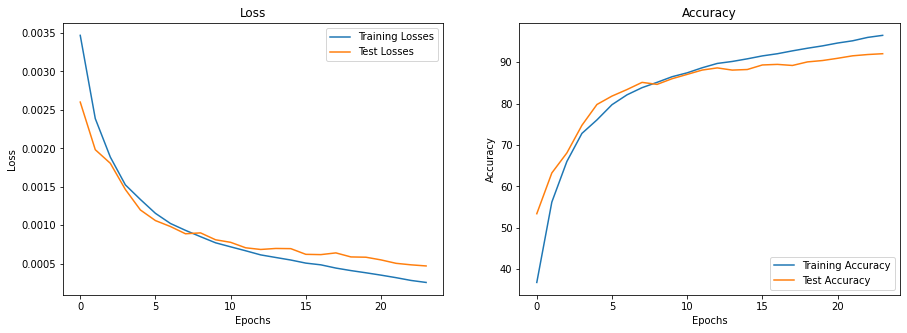

In [16]:
plot_acc_loss(train_acc,train_losses,test_acc,test_losses)

# Display wrong prediction

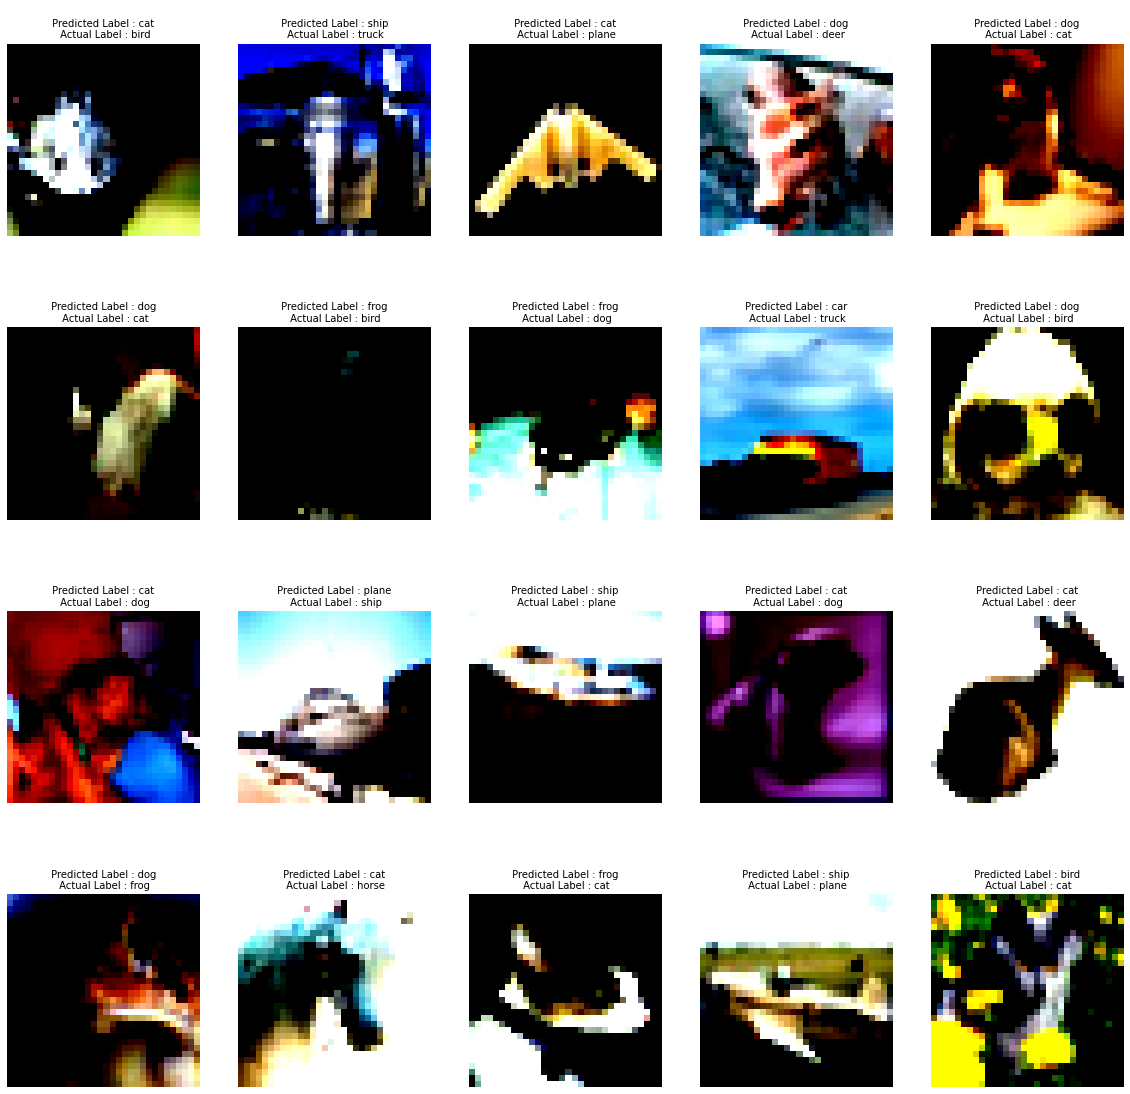

In [17]:
display_incorrect_pred(wrong_prediction_list)

# GradCam 

In [18]:
target_layers = ["layer1", "layer2","layer3"]
torch.autograd.set_detect_anomaly(True)

In [19]:
from main_repo.utils import generate_gradcam, plot_gradcam
gradcam_output, probs, predicted_classes = generate_gradcam(wrong_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


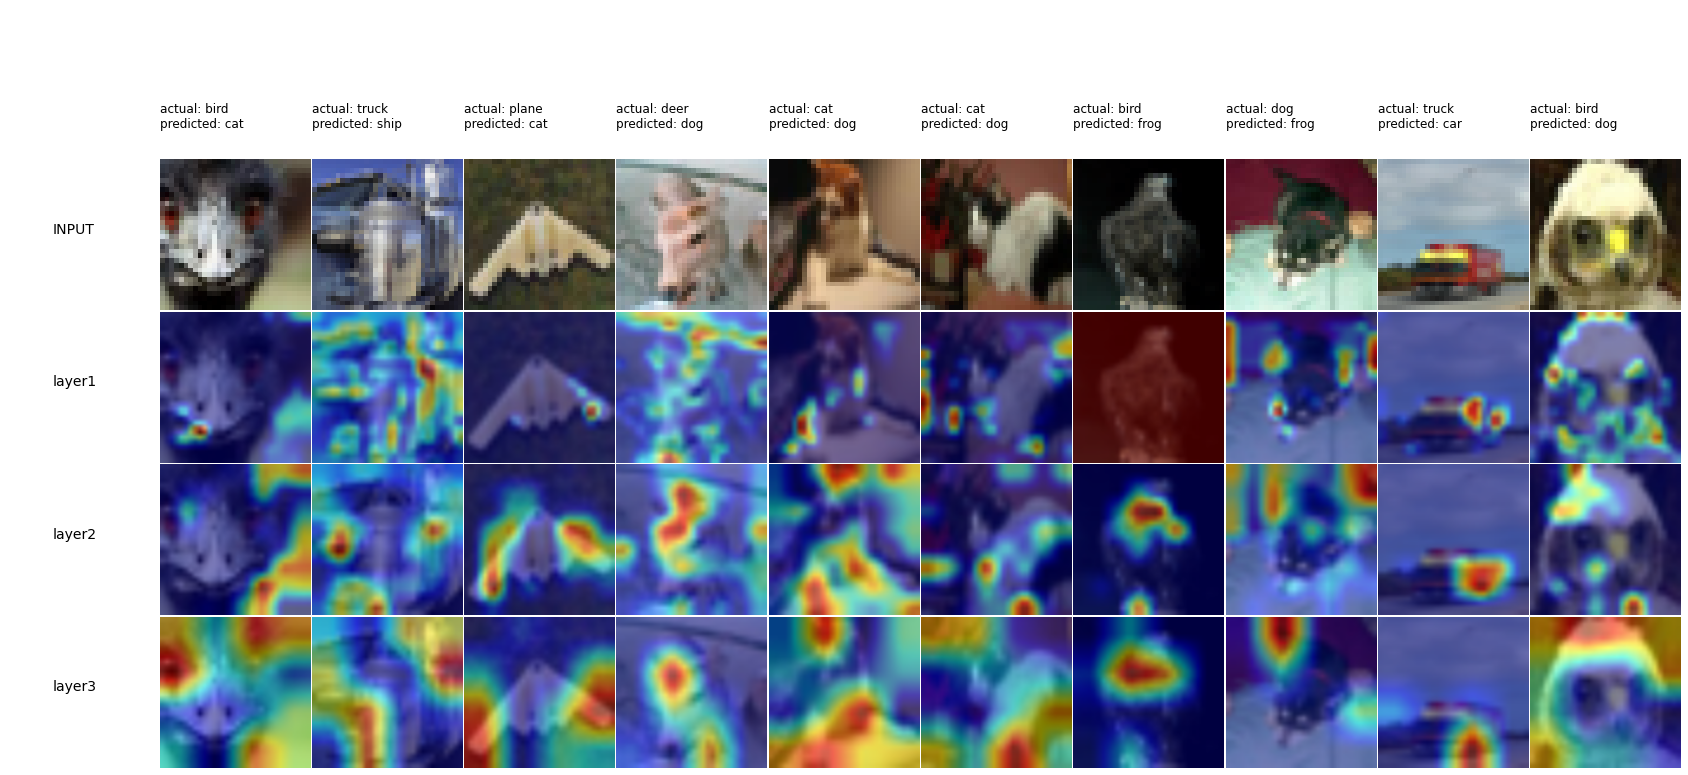

In [20]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, wrong_prediction_list[:10],mean,std)

In [21]:
gradcam_output, probs, predicted_classes = generate_gradcam(right_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


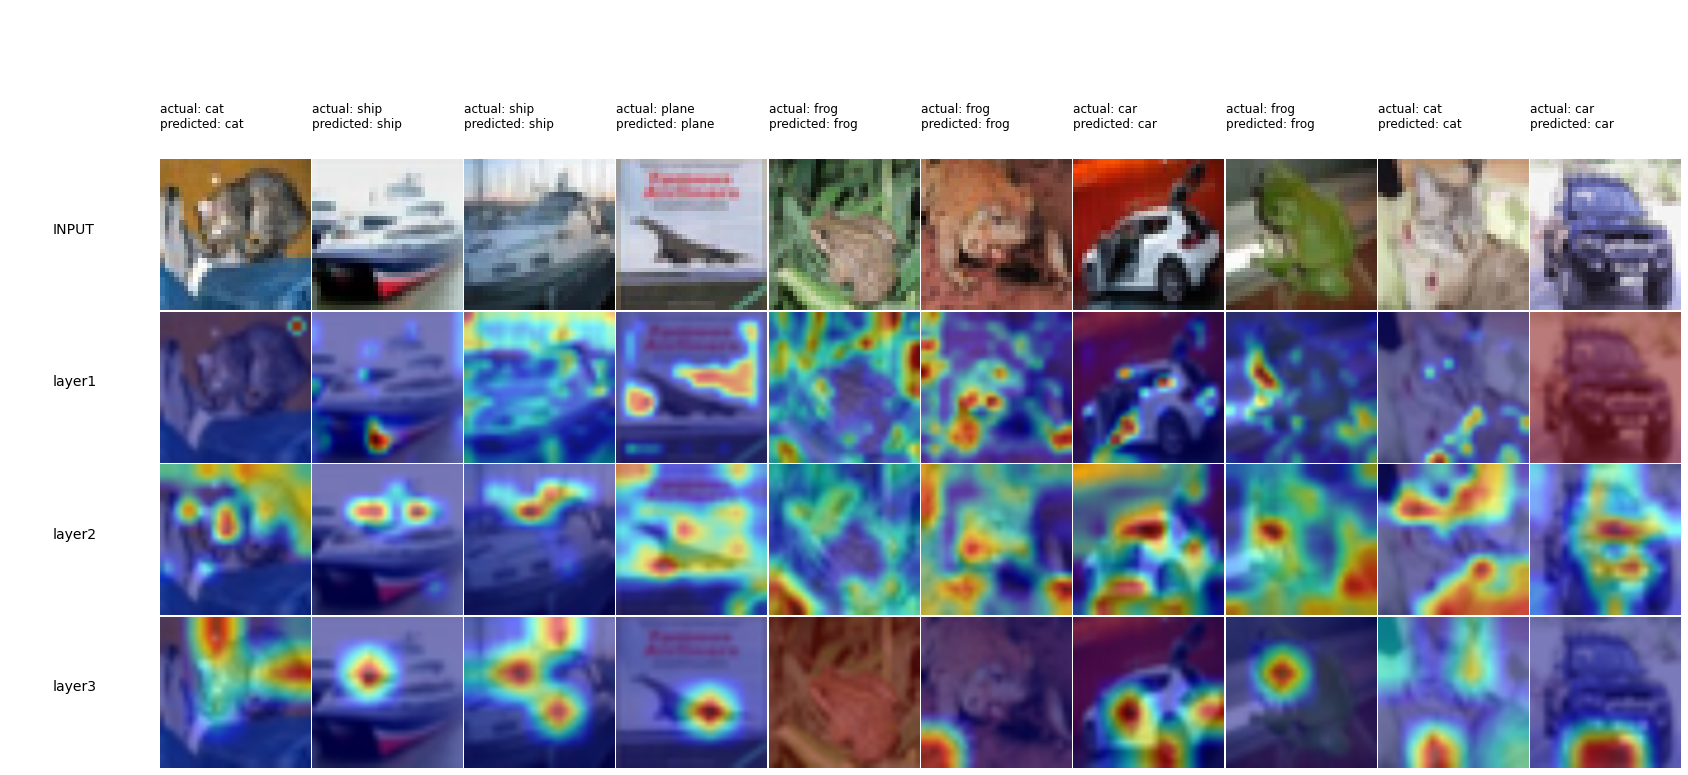

In [22]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, right_prediction_list[:10],mean,std)